##### This notebook requires loading mpd_track_map.csv and combined_feats_df.csv. We standardize track audio features before computing standard deviations of each feature by playlist as a measure of within-playlist diversity. We also visualize audio feature contribution to diversity by feature. Finally, we produce a scaled diversity score between 0 and 1 for each playlist.

In [14]:
import pandas as pd
import numpy as np
import sklearn

In [15]:
mpd_df = pd.read_csv("mpd_track_map.csv")
track_features_df = pd.read_csv("combined_feats_df.csv")

Standardized Audio Features Before Calculating Within-Playlist Diversity

In [3]:
track_features_df = pd.read_csv("combined_feats_df.csv")
track_features_df.head()

,artist_name,track_name,track_id,popularity,genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,acoustic,0.483,0.303,-10.058,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,acoustic,0.572,0.454,-10.286,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,acoustic,0.409,0.234,-13.711,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,acoustic,0.392,0.251,-9.845,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,acoustic,0.430,0.791,-5.419,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320


In [16]:
# Standardization
from sklearn.preprocessing import StandardScaler

# Keep track_id and metadata to preserve
meta_cols = ["track_id", "track_name", "artist_name", "genre", "popularity", "tempo", "duration_ms"]
feature_cols = [col for col in track_features_df.columns if col not in meta_cols]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(track_features_df[feature_cols])

# Put back into a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
scaled_df["track_id"] = track_features_df["track_id"]


In [17]:
# Join to get standardized feature values for each track in each playlist
merged_df = mpd_df.merge(scaled_df, on="track_id", how="inner")

In [18]:
# Filter out playlists with fewer than 20 tracks
playlist_sizes = merged_df.groupby("playlist_id").size()
valid_playlists = playlist_sizes[playlist_sizes >= 10].index
merged_df = merged_df[merged_df["playlist_id"].isin(valid_playlists)]

In [19]:
# Group by playlist_id and compute SD per feature
playlist_feature_sd = merged_df.groupby("playlist_id")[feature_cols].std()

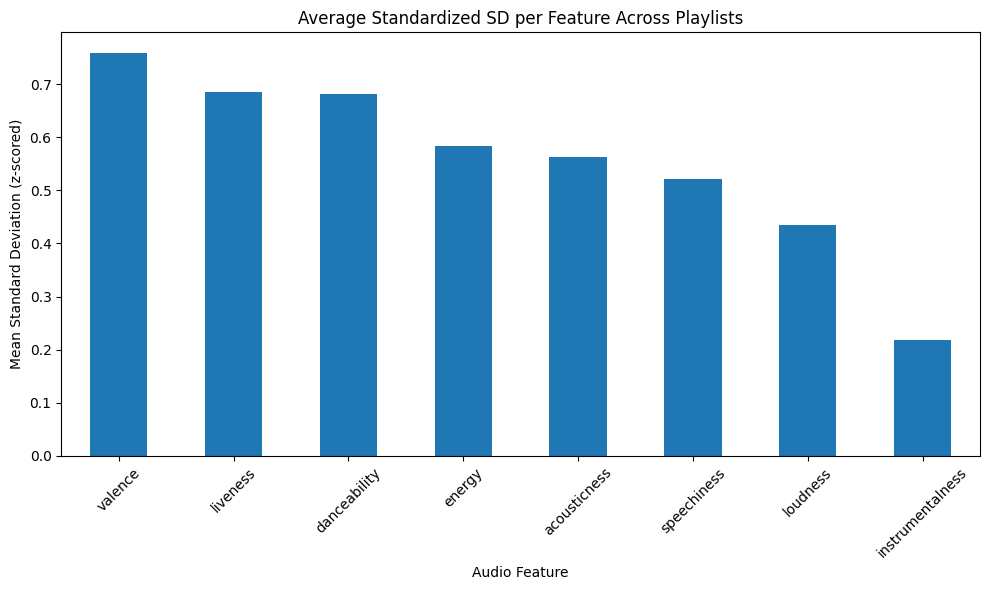

In [20]:
# which audio features vary the most within playlists, i.e. diversity contributions by feature
feature_diversity = playlist_feature_sd.mean().sort_values(ascending=False)

# visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_diversity.plot(kind="bar")
plt.title("Average Standardized SD per Feature Across Playlists")
plt.ylabel("Mean Standard Deviation (z-scored)")
plt.xlabel("Audio Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# computing diversity scores for each playlist where mean SD across all features = diversity score
playlist_feature_sd['diversity_score'] = playlist_feature_sd.mean(axis=1)

In [22]:
# standardizing diversity scores (between 0 and 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
playlist_feature_sd['diversity_score_scaled'] = scaler.fit_transform(
    playlist_feature_sd[['diversity_score']]
)

In [23]:
# df of playlists with audio features and scaled within-playlist diversity score
playlist_feature_sd.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,diversity_score,diversity_score_scaled
playlist_id,,,,,,,,,,
0,0.816158,0.538485,0.254430,0.740683,0.404926,0.013129,0.850835,0.748315,0.545870,0.415634
1,0.601288,0.690305,0.340408,1.008941,0.545757,0.509599,0.751342,0.777782,0.653178,0.497340
2,0.556185,0.660666,0.349388,0.566637,0.691453,0.017855,0.534629,0.757204,0.516752,0.393463
3,0.922418,0.915293,0.882509,0.426098,0.966007,1.003456,0.458668,0.912016,0.810808,0.617363
5,0.672788,0.537471,0.352364,0.355319,0.447404,0.010718,0.637996,0.815903,0.478746,0.364525


In [24]:
playlist_feature_sd.shape

(785769, 10)